
# Генератор псевдо-случайных чисел (ГПСЧ)

In [12]:
import random
import math
from scipy import stats 


### ГПСЧ формирующий последовательность равномерно распределённых на отрезке [0;1] чисел 

In [13]:
def uniform(seed, n):   #линейно-конгуэнтный метод
    a = 1664525
    c = 1013904223
    m = 2**32 #период 
    numbers = []
    x = seed
    for _ in range (n):
        x = (a * x + c ) % m
        numbers.append(x / m )
    return numbers 

def kolmogorov_smirnov_test(data, distribution, alpha = 0.01):
    statistic, p_value = stats.kstest(data, distribution)
    return p_value > alpha 

sample_size = 1000
data_1 = uniform( seed = 123, n = sample_size)
is_data_good = kolmogorov_smirnov_test(data_1, 'uniform', alpha = 0.01)
is_data_good 


True

### ГПСЧ формирующий последовательность экспоненциально распределённых чисел  с параметром λ>0 

In [14]:
def exponential(lambda_val, n):
    numbers = []
    for _ in range(n):          # метод обратной функции
        u = random.random()
        x = -1 / lambda_val * math.log(1 - u)
        numbers.append(x)
    return numbers 

def anderson_darling_test(data, distribution):
    result = stats.anderson(data, dist = distribution)
    return result.statistic < result.critical_values[2]

sample_size = 1000
lambda_val = 0.5
data_2 = exponential(lambda_val, sample_size )
is_data2_good = anderson_darling_test(data_2, 'expon')
is_data2_good
    

True

### ГПСЧ формирующий послдовательность нормально распределённых чисел с параметрами (0, 1)

In [15]:
def normal(n):
    numbers = []
    for _ in range(n):
        u1, u2 = random.random(), random.random()           # преобразования Бокса-Мюллера 
        z1 = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
        z2 = math.sqrt(-2 * math.log(u1)) * math.sin(2 * math.pi * u2)
        numbers.extend([z1, z2])
    return numbers


def kolmogorov_smirnov_test(data, distribution, alpha = 0.01):
    statistic, p_value = stats.kstest(data, distribution)
    return p_value > alpha 

sample_size = 1000
data_3 = normal(sample_size)
is_data3_good = kolmogorov_smirnov_test(data_3, 'norm', alpha = 0.01)
is_data3_good

True


# Построение моделей основных случайных процессов

### Модель винеровского процесса

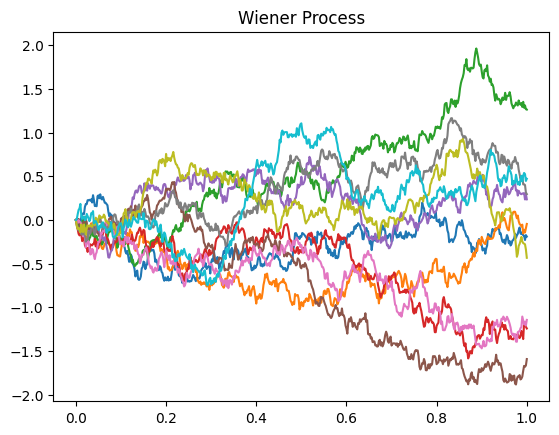

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def wiener_process(T, n, path ):
    dt = T / float(n)
    t = np.linspace(0.0, T, n+1)
    W = np.zeros((path, n+1))

    for j in range(path):
        for i in range(1, n+1):
            dW = np.random.normal(loc=0.0, scale=np.sqrt(dt))
            W[j, i] = W[j, i-1] + dW

    return t, W

T , n, path = 1.0, 500, 10  
t, W = wiener_process(T, n, path)

for j in range(path):
    plt.plot(t, W[j])

plt.title('Wiener Process')
plt.show()

### Модель пуассоновского процесса 1

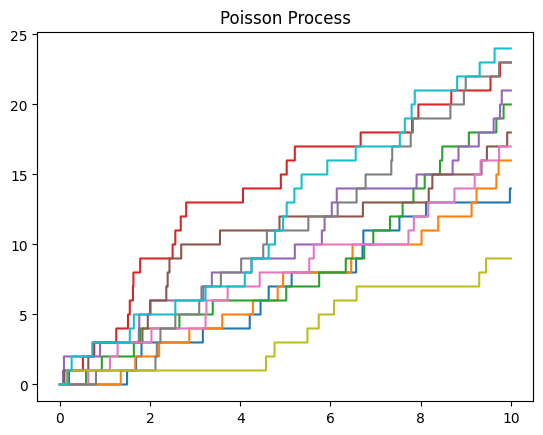

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def poisson_process_sum(lmbda, T, n, path):
    dt = T / float(n)
    t = np.arange(0.0, T + dt, dt)
    
    processes = np.zeros((path, n + 1))
    
    for i in range(path):
        ksi = np.random.binomial(1, lmbda * dt, n + 1)
        process = np.cumsum(ksi)
        processes[i] = process
    
    return t, processes

lmbda = 2.0  
T = 10.0     
n = 1000     
path = 10

t, processes = poisson_process_sum(lmbda, T, n, path)

for i in range(path):
    plt.step(t, processes[i], where='post')
plt.title('Poisson Process')
plt.show()

### Модель пуассоновского процесса 2

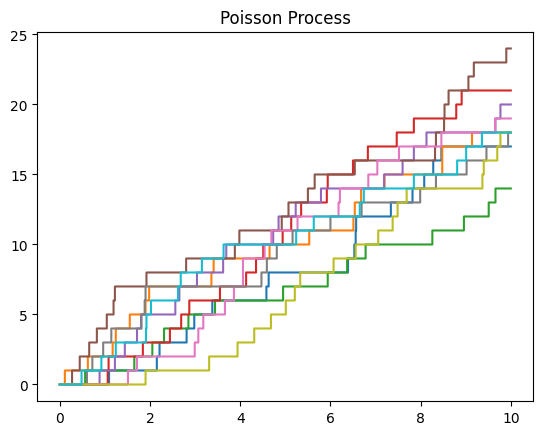

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def poisson_process_max(lmbda, T, n, path):
    t = np.linspace(0.0, T, n + 1)
    
    processes = np.zeros((path, n + 1))
    
    for i in range(path):
        ksi = np.random.exponential(1.0 / lmbda, n)
        
        sum_ksi = np.cumsum(ksi)
    
        process = np.zeros(n + 1)
        for j in range(n + 1):
            if np.any(sum_ksi <= t[j]):
                process[j] = np.max(np.where(sum_ksi <= t[j]))
        
        processes[i] = process
    
    return t, processes

lmbda = 2.0  
T = 10.0     
n = 1000     
path = 10

t, processes = poisson_process_max(lmbda, T, n, path)

for i in range(path):
    plt.step(t, processes[i], where='post')

plt.title('Poisson Process')
plt.show()

### Моделирование точечного процесса

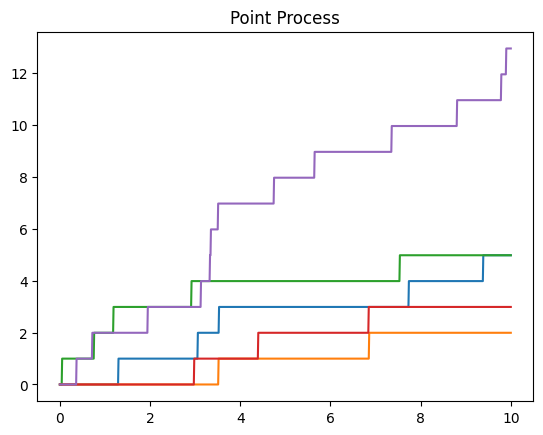

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def point_process(b, T, n, path):
    dt = T / float(n)
    t = np.arange(0.0, T + dt, dt)
    
    processes = np.zeros((path, n + 1))
    
    for i in range(path):
        B = np.random.poisson(lam=b * dt, size=n + 1)
        D = np.cumsum(B)
        A = b * D * dt
        process = D - A
        processes[i] = process
    
    return t, processes

b = 0.5  
T = 10.0 
n = 1000 
path = 5 

t, processes = point_process(b, T, n, path)
for i in range(path):
    plt.plot(t, processes[i])

plt.title('Point Process')
plt.show()

### Моделирование процесса размножения и гибели 

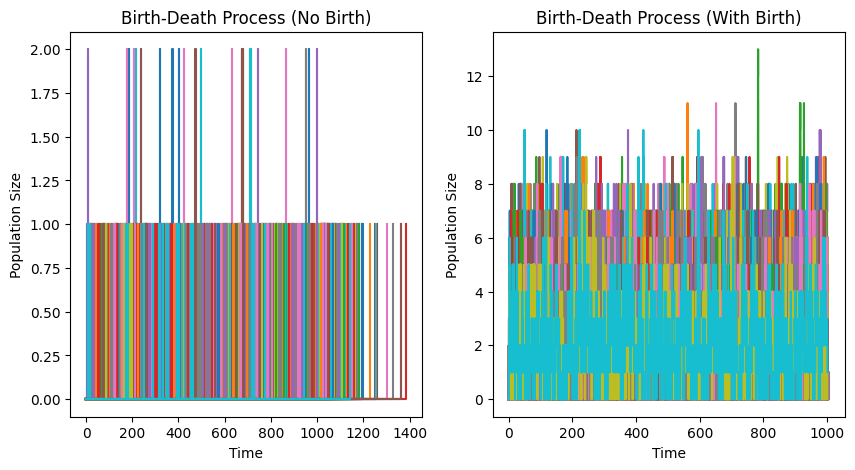

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def birth_death_process(lmbda, mu, T, path):
    t = [0.0]
    X = [0]
    
    processes = []
    
    for i in range(path):
        while t[-1] < T:
            dt = np.random.exponential(scale=1.0 / (lmbda + mu * X[-1])) # случайный интервал между событиями рождения и смерти
            t.append(t[-1] + dt)
            p = lmbda / (lmbda + mu * X[-1]) #произошло событие рождения или смерти ?
            event = np.random.binomial(1, p)
            
            if event == 1:             # Обновляем численность популяции
                X.append(X[-1] + 1)    # Событие рождения
            else:
                X.append(max(X[-1] - 1, 0))  # Событие смерти
        
        processes.append((t, X))

        t = [0.0]
        X = [0]
    
    return processes

mu = 0.5     # Интенсивность смерти
T = 1000     
path = 100  

# 1) Новые особи НЕ рождаются
lmbda = 0.01  # Интенсивность рождения
processes_1 = birth_death_process(lmbda, mu, T, path)

# 2) Новые особи рождаются
lmbda = 1.0  # Интенсивность рождения
processes_2 = birth_death_process(lmbda, mu, T, path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
for t, X in processes_1:
    plt.step(t, X, where='post')

plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Birth-Death Process (No Birth)')

plt.subplot(1, 2, 2)
for t, X in processes_2:
    plt.step(t, X, where='post')

plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Birth-Death Process (With Birth)')

plt.show()


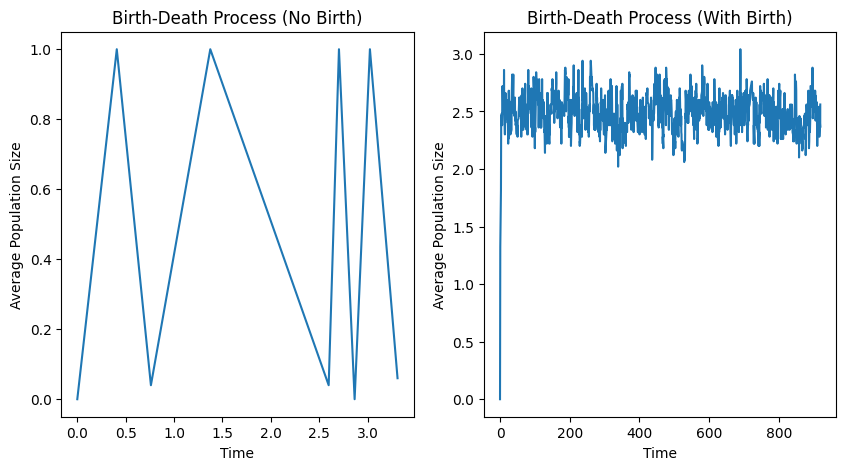

In [54]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
last_t = min([t[-1] for t, X in processes_1]) # ср значение популяции по всем траекториям
min_idx = min([np.searchsorted(t, last_t) for t, X in processes_1])
X_trimmed = [X[:min_idx] for t, X in processes_1]
mean_X_1 = np.mean(X_trimmed, axis=0)
plt.plot(t[:len(mean_X_1)], mean_X_1)

plt.xlabel('Time')
plt.ylabel('Average Population Size')
plt.title('Birth-Death Process (No Birth)')

plt.subplot(1, 2, 2)
last_t = min([t[-1] for t, X in processes_2])
min_idx = min([np.searchsorted(t, last_t) for t, X in processes_2])
X_trimmed = [X[:min_idx] for t, X in processes_2]
mean_X_2 = np.mean(X_trimmed, axis=0)
plt.plot(t[:len(mean_X_2)], mean_X_2)

plt.xlabel('Time')
plt.ylabel('Average Population Size')
plt.title('Birth-Death Process (With Birth)')

plt.show()
